# Project Header

In this project, we are looking at actigraphy data sourced from the [Depresjon](https://datasets.simula.no/depresjon/) dataset with the goal of developing a classification algorithm to aid in non-invasive recognition of those with a Major Depressive Disorder. The study included 32 healthy and 23 afflicted participants and collected activity data through participant's continual wearing of a watch containing an accelerometer. A record exists for each minute over 13 or more days where the activity associated with each minute is the sum of the number of movements with an acceleration greater than .5g. Related literature includes:

* Enrique Garcia-Ceja, Michael Riegler, Petter Jakobsen, Jim Tørresen, Tine Nordgreen, Ketil J. Oedegaard, and Ole Bernt Fasmer. 2018. Depresjon: a motor activity database of depression episodes in unipolar and bipolar patients. In Proceedings of the 9th ACM Multimedia Systems Conference (MMSys '18). Association for Computing Machinery, New York, NY, USA, 472–477. DOI:https://doi.org/10.1145/3204949.3208125

* Pacheco-Gonzalez, S.L., Zanella-Calzada, L.A., Galvan-Tejada, C.E., Chavez-Lamas, N.M., Rivera-Gomez, J.F., abnd Galvan-Tejada, J.I.. 2019. Evaluation of five classifiers for depression episodes detection, *Res. Comput. Sci.*, vol. 148, pp. 129-138.

* Rodríguez-Ruiz, J.G., Galván-Tejada, C.E., Vázquez-Reyes, S. et al. Classification of Depressive Episodes Using Nighttime Data; a Multivariate and Univariate Analysis. Program Comput Soft 46, 689–698 (2020). https://doi.org/10.1134/S0361768820080198

* Zanella-Calzada LA, Galván-Tejada CE, Chávez-Lamas NM, Gracia-Cortés MDC, Magallanes-Quintanar R, Celaya-Padilla JM, Galván-Tejada JI, Gamboa-Rosales H. Feature Extraction in Motor Activity Signal: Towards a Depression Episodes Detection in Unipolar and Bipolar Patients. Diagnostics (Basel). 2019 Jan 10;9(1):8. doi: https://10.3390/diagnostics9010008. PMID: 30634621; PMCID: PMC6468429.

# This Notebook

In this notebook we will be doing our initial exploration and pre-processing of the data. We hope to increase the ability of classification algorithms to make predictions through addition of features that quantify and qualify data as it is divided into time sections for patients.

## Importing Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

In [2]:
condition_list = glob("./data/condition/*.csv")
control_list = glob("./data/control/*.csv")
cleaned_conditions = [filename.split('\\')[1].replace('.csv', '')
                     for filename in condition_list]
cleaned_controls = [filename.split('\\')[1].replace('.csv', '')
                     for filename in control_list]

In [3]:
condition_dfs = {}
control_dfs = {}
for idx,file in enumerate(condition_list):
    condition_dfs.update({cleaned_conditions[idx]: pd.read_csv(file)})
for idx,file in enumerate(control_list):
    control_dfs.update({cleaned_controls[idx]: pd.read_csv(file)})

In [4]:
condition_dfs['condition_1'].head()

,timestamp,date,activity
0,2003-05-07 12:00:00,2003-05-07,0
1,2003-05-07 12:01:00,2003-05-07,143
2,2003-05-07 12:02:00,2003-05-07,0
3,2003-05-07 12:03:00,2003-05-07,20
4,2003-05-07 12:04:00,2003-05-07,166


In [5]:
condition_dfs['condition_1'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23244 entries, 0 to 23243
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  23244 non-null  object
 1   date       23244 non-null  object
 2   activity   23244 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 544.9+ KB


In [6]:
type(condition_dfs['condition_5'].iloc[0].timestamp)
test_stamp = pd.to_datetime(condition_dfs['condition_5'].iloc[0].timestamp)
print(test_stamp)
print(test_stamp.hour)

2003-06-12 10:30:00
10


Okay, so we can fix up these dataframes a little to start to make them easier to work with. Since we can cast the timestamp column into a datetime obj, we can get rid of the date column as it becomes redundant. So, let's recast timestamp and drop date for each dataframe.

In [7]:
for df in condition_dfs:
    condition_dfs[df] = condition_dfs[df].drop(columns = 'date')
    condition_dfs[df].timestamp = pd.to_datetime(condition_dfs[df].timestamp)

In [8]:
for df in control_dfs:
    control_dfs[df] = control_dfs[df].drop(columns = 'date')
    control_dfs[df].timestamp = pd.to_datetime(control_dfs[df].timestamp)

In [9]:
for patient in condition_dfs:
    print(condition_dfs[patient].shape[0]/60/24)

16.141666666666666
14.96875
15.965277777777779
15.379861111111111
17.993055555555554
15.031944444444443
15.159027777777778
29.06041666666667
14.952083333333334
14.824305555555556
14.74375
27.031944444444445
17.949305555555558
14.227083333333333
15.119444444444445
21.864583333333332
15.033333333333333
14.969444444444443
14.925694444444444
14.884027777777776
15.399305555555555
13.402083333333332
14.109722222222222


In [10]:
for patient in control_dfs:
    print(control_dfs[patient].shape[0]/60/24)

35.84097222222222
15.038194444444445
17.20277777777778
24.053472222222222
15.456249999999999
15.457638888888889
15.460416666666667
17.050694444444442
20.072916666666668
17.093055555555555
19.172916666666666
21.85625
22.146527777777777
22.177777777777777
15.06111111111111
15.065277777777778
15.155555555555557
15.151388888888889
23.17013888888889
14.229166666666666
17.038888888888888
16.96736111111111
45.421527777777776
15.047916666666666
35.68680555555556
35.84652777777778
21.84375
32.731249999999996
35.825694444444444
35.75694444444444
20.081944444444442
20.165277777777778


Hmm.. so the subjects did not wear the watches for a standard number of days. In fact, there is a pretty wide distribution in the amount of time the watch was worn, from a minimum near 13 days all the way up to a maximum in the control group for 45 days. I think the first thing I would like to do is determine how to efficiently establish sleeping vs not sleeping for each patient. I think in the future I will have to group the data into hour or half-hour lapses, based on the literature, so I will have to decide between making partial-hour cutoffs at hard sleep vs not sleep divisions, or decide on some metric in which the subject is primarily awake or asleep during pre-defined hour divisions.

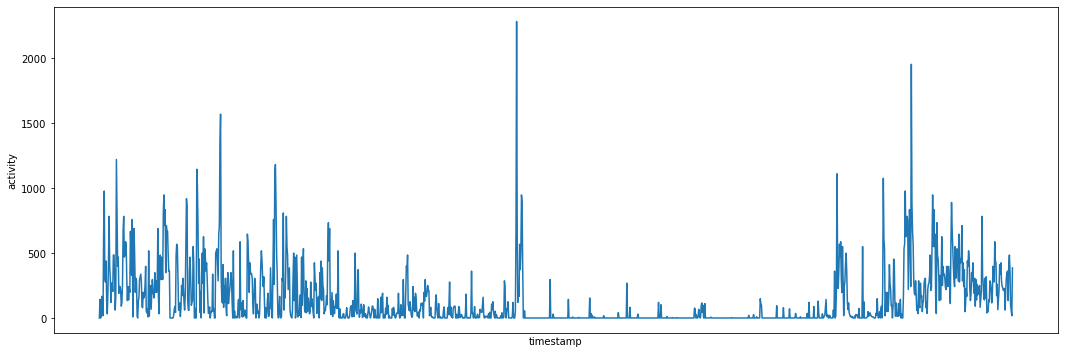

In [11]:
fig1, ax1 = plt.subplots(figsize = (18,6));
sns.lineplot(data = condition_dfs['condition_1'].iloc[:1500], x = 'timestamp', y = 'activity');
ax1.axes.xaxis.set_ticks([]);

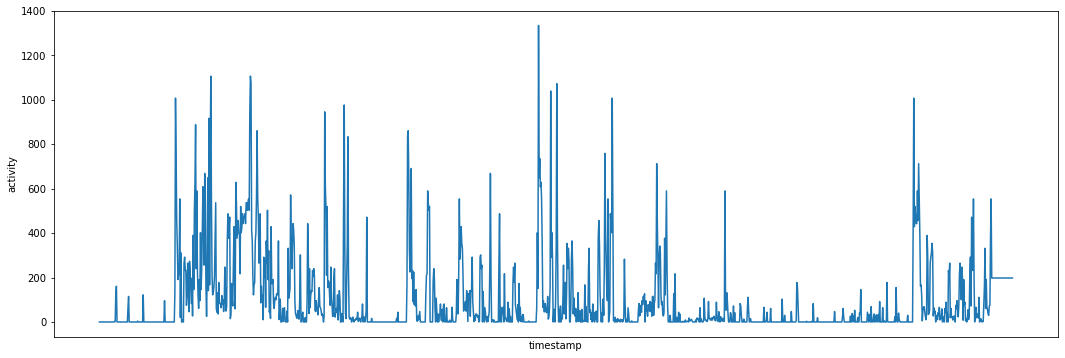

In [12]:
fig3, ax3 = plt.subplots(figsize = (18,6));
sns.lineplot(data = condition_dfs['condition_5'].iloc[:1500], x = 'timestamp', y = 'activity');
ax3.axes.xaxis.set_ticks([]);

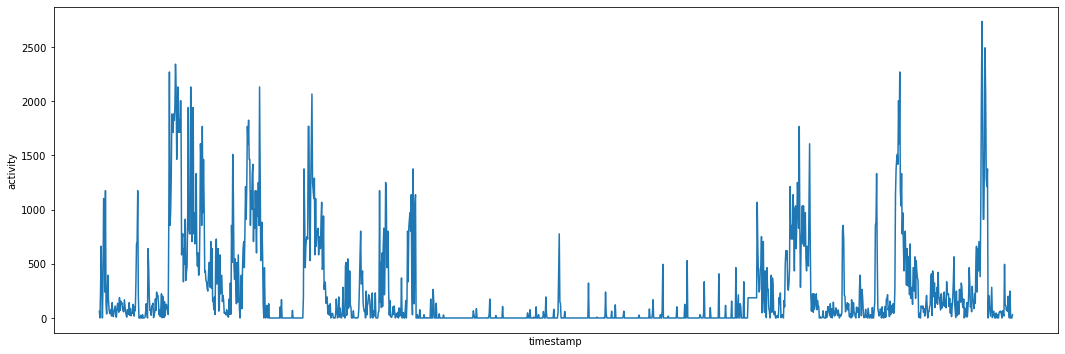

In [13]:
fig2, ax2 = plt.subplots(figsize = (18,6));
sns.lineplot(data = control_dfs['control_1'].iloc[:1500], x = 'timestamp', y = 'activity');
ax2.axes.xaxis.set_ticks([]);

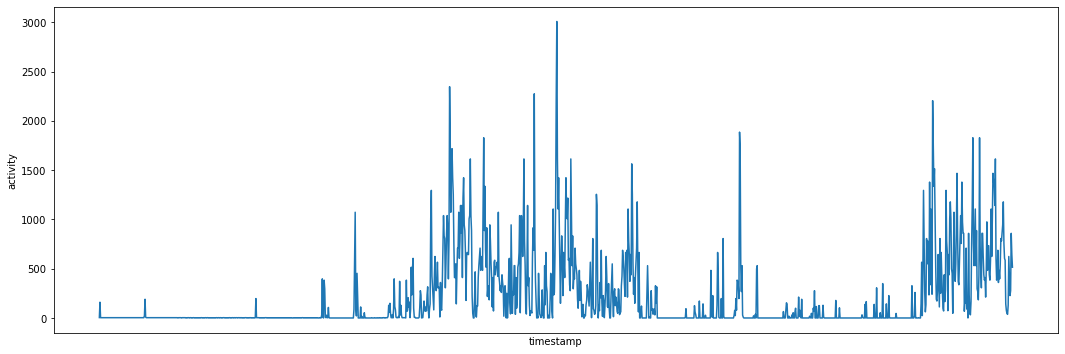

In [14]:
fig4, ax4 = plt.subplots(figsize = (18,6));
sns.lineplot(data = control_dfs['control_8'].iloc[:1500], x = 'timestamp', y = 'activity');
ax4.axes.xaxis.set_ticks([]);

In [15]:
condition_dfs['condition_1'].iloc[0]

timestamp    2003-05-07 12:00:00
activity                       0
Name: 0, dtype: object

In [16]:
control_dfs['control_1'].iloc[0]

timestamp    2003-03-18 15:00:00
activity                      60
Name: 0, dtype: object

In [17]:
condition_dfs['condition_1'].iloc[:60]

,timestamp,activity
0,2003-05-07 12:00:00,0
1,2003-05-07 12:01:00,143
2,2003-05-07 12:02:00,0
3,2003-05-07 12:03:00,20
4,2003-05-07 12:04:00,166
5,2003-05-07 12:05:00,160
6,2003-05-07 12:06:00,17
7,2003-05-07 12:07:00,646
8,2003-05-07 12:08:00,978
9,2003-05-07 12:09:00,306


In [18]:
peaks_arr = abs(np.fft.rfft(control_dfs['control_1'][:60].activity))

In [19]:
peaks_arr

array([9389.        , 4365.60610338, 4584.7427142 , 2874.08137289,
       2260.48822866, 1394.34130491, 1036.73907594, 1164.53276011,
       1195.02218732, 1983.31198078, 1743.41647348, 1964.22467956,
        912.74717497,  902.06917342, 1377.10909598, 1677.90136778,
       2419.40392411, 1997.70896159, 1741.47066826, 1592.62712753,
       1265.78473683, 1252.0688921 , 1212.09788082, 1279.70051232,
       1136.98926758, 1272.04886912, 1560.61446541, 1120.86811817,
       1190.35859804, 1376.75261087,  603.        ])

In [20]:
n = control_dfs['control_1'][:60].activity.size
freq_arr = np.fft.rfftfreq(n, d = 60)

In [21]:
print(len(freq_arr))
print(len(peaks_arr))
print(n)

31
31
60


In [22]:
freq_arr

array([0.        , 0.00027778, 0.00055556, 0.00083333, 0.00111111,
       0.00138889, 0.00166667, 0.00194444, 0.00222222, 0.0025    ,
       0.00277778, 0.00305556, 0.00333333, 0.00361111, 0.00388889,
       0.00416667, 0.00444444, 0.00472222, 0.005     , 0.00527778,
       0.00555556, 0.00583333, 0.00611111, 0.00638889, 0.00666667,
       0.00694444, 0.00722222, 0.0075    , 0.00777778, 0.00805556,
       0.00833333])

<AxesSubplot:>

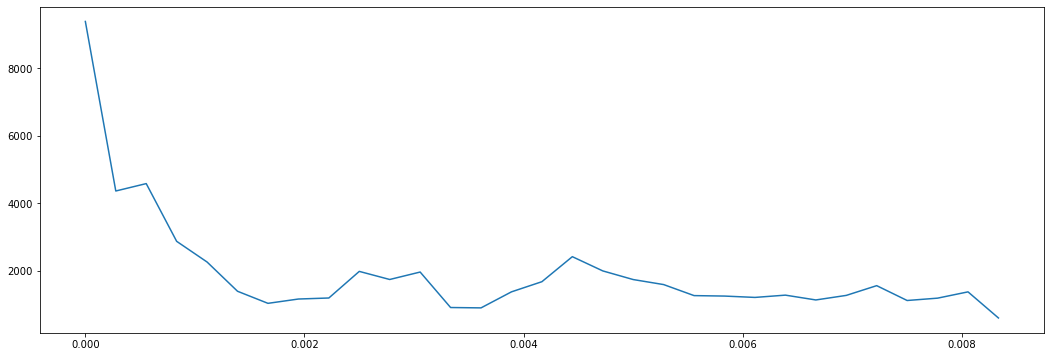

In [23]:
fig5, ax5 = plt.subplots(figsize = (18,6))
sns.lineplot(y=peaks_arr,x=freq_arr)

<AxesSubplot:>

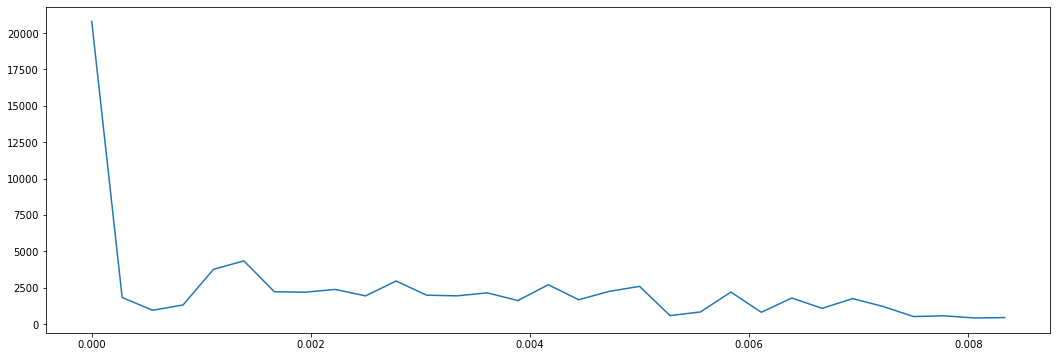

In [24]:
peaks_arr = abs(np.fft.rfft(condition_dfs['condition_1'][:60].activity))
fig6, ax6 = plt.subplots(figsize = (18,6))
sns.lineplot(y=peaks_arr,x=freq_arr)

<AxesSubplot:>

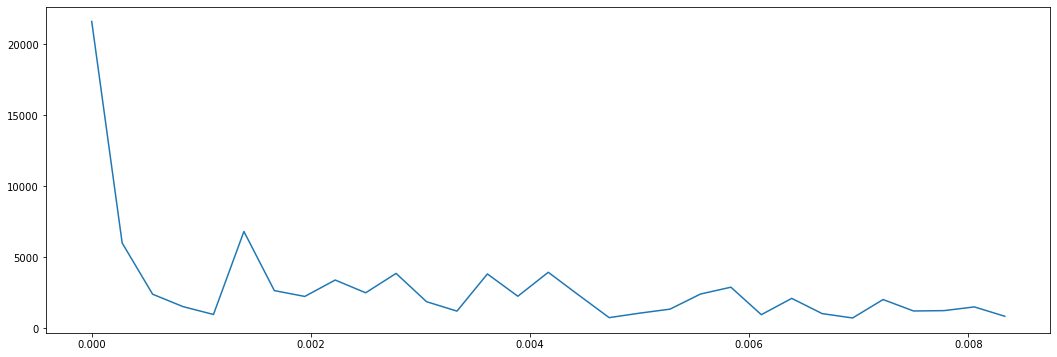

In [25]:
peaks_arr = abs(np.fft.rfft(condition_dfs['condition_2'][:60].activity))
fig7, ax7 = plt.subplots(figsize = (18,6))
sns.lineplot(y=peaks_arr,x=freq_arr)

<AxesSubplot:>

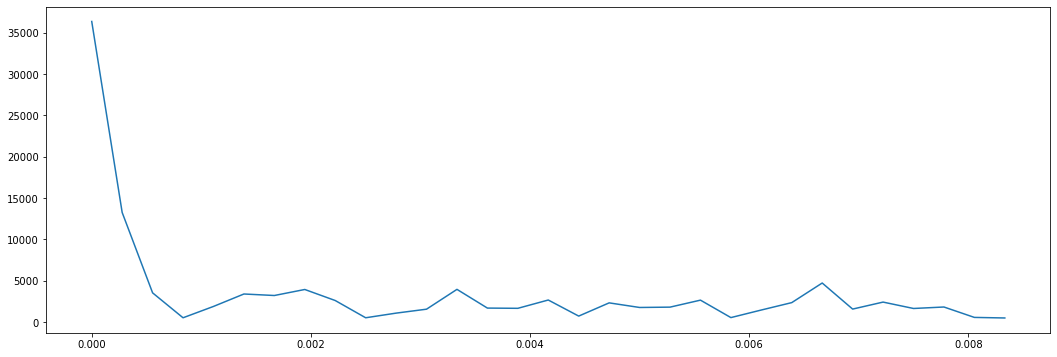

In [26]:
peaks_arr = abs(np.fft.rfft(control_dfs['control_2'][:60].activity))
fig8, ax8 = plt.subplots(figsize = (18,6))
sns.lineplot(y=peaks_arr,x=freq_arr)

<AxesSubplot:>

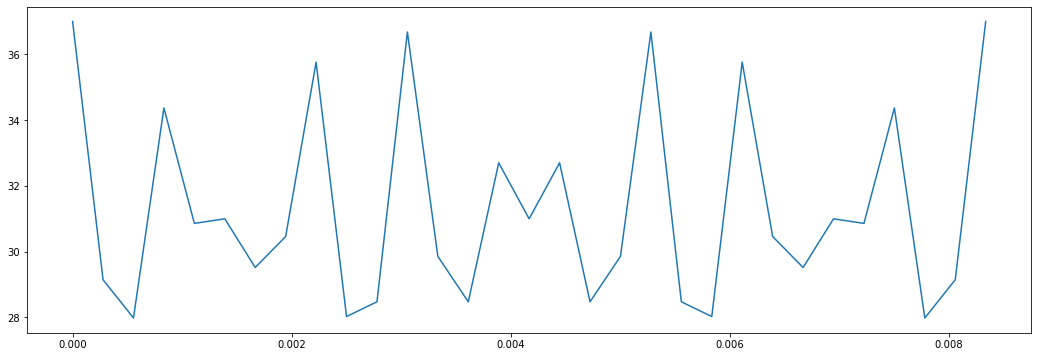

In [27]:
peaks_arr = abs(np.fft.rfft(control_dfs['control_3'][:60].activity))
fig9, ax9 = plt.subplots(figsize = (18,6))
sns.lineplot(y=peaks_arr,x=freq_arr)

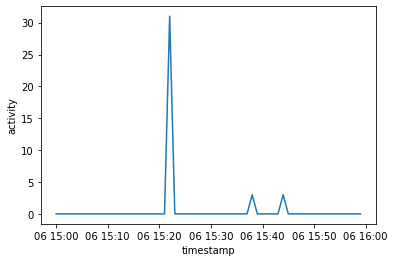

In [28]:
sns.lineplot(data = control_dfs['control_3'].iloc[:60], x = 'timestamp', y = 'activity');

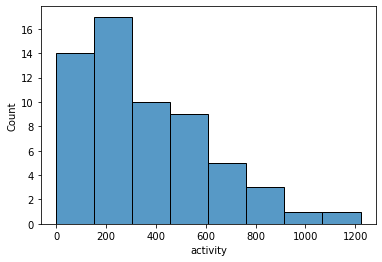

In [29]:
sns.histplot(data = condition_dfs['condition_1'].iloc[:60], x = 'activity');

<AxesSubplot:>

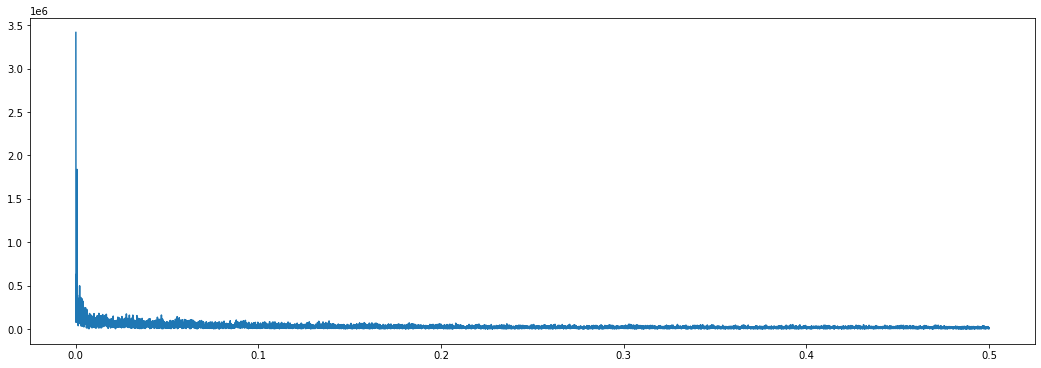

In [30]:
peaks_arr = abs(np.fft.rfft(condition_dfs['condition_1'].activity))
n = len(condition_dfs['condition_1'].activity)
freq_arr = np.fft.rfftfreq(n)
fig6, ax6 = plt.subplots(figsize = (18,6))
sns.lineplot(y=peaks_arr,x=freq_arr)

<AxesSubplot:>

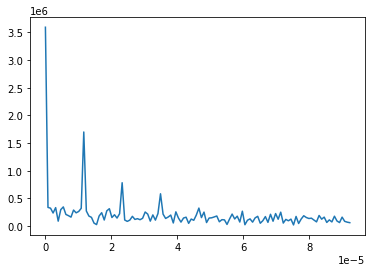

In [31]:
N = len(condition_dfs['condition_5'].activity)
T = N * 60
fs = 1/60
peaks_arr = abs(np.fft.rfft(condition_dfs['condition_5'].activity))
freq_arr = np.fft.rfftfreq(N, d = 1/fs)
sns.lineplot(y=peaks_arr[:120],x=freq_arr[:120])

In [32]:
sorted(zip(peaks_arr[freq_arr >= 1e-5],freq_arr[freq_arr >= 1e-5]),reverse = True)[:10]

[(1701369.04892939, 1.1631694039919974e-05),
 (784291.7343873837, 2.326338807983995e-05),
 (584490.3283857745, 3.489508211975992e-05),
 (325972.03110379097, 4.65267761596799e-05),
 (321886.9971762392, 1.0856247770591976e-05),
 (314704.12906671496, 1.9386156733199956e-05),
 (278023.33151189657, 0.00011864327920718374),
 (275914.3356154133, 1.8610710463871958e-05),
 (273559.5644537683, 1.2407140309247973e-05),
 (269634.76481982926, 5.970936273825587e-05)]

In [33]:
freq_tups = sorted(zip(peaks_arr[freq_arr >= 1e-5],freq_arr[freq_arr >= 1e-5]),reverse = True)[:10]
for tup in freq_tups:
    print(1/tup[1]/60/60)

23.88111111111111
11.940555555555555
7.96037037037037
5.970277777777778
25.586904761904762
14.328666666666667
2.341285403050109
14.925694444444444
22.388541666666665
4.652164502164502


<AxesSubplot:>

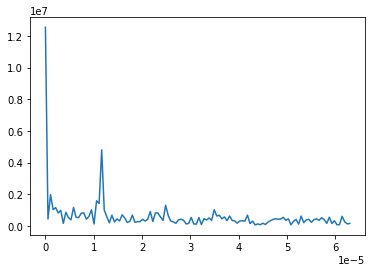

In [34]:
N = len(control_dfs['control_2'].activity)
T = N * 60
fs = 1/60
peaks_arr = abs(np.fft.rfft(control_dfs['control_2'].activity))
freq_arr = np.fft.rfftfreq(N, d = 1/fs)
sns.lineplot(y=peaks_arr[:120],x=freq_arr[:120])

In [35]:
sorted(zip(peaks_arr[freq_arr >= 1e-5],freq_arr[freq_arr >= 1e-5]),reverse = True)[:10]

[(4808292.7867452, 1.1650197523803473e-05),
 (1582671.7747243114, 1.0591088658003157e-05),
 (1415594.0608849267, 1.1120643090903316e-05),
 (1298575.6201410312, 2.488905834630742e-05),
 (1019157.7823709416, 3.495059257141042e-05),
 (1004696.3527185008, 1.217975195670363e-05),
 (936112.5978759036, 6.937163070992068e-05),
 (908365.3667217366, 2.1711731748906473e-05),
 (818843.5814752674, 2.2770840614706787e-05),
 (816490.4573502366, 2.3300395047606946e-05)]

In [36]:
freq_tups = sorted(zip(peaks_arr[freq_arr >= 1e-5],freq_arr[freq_arr >= 1e-5]),reverse = True)[:10]
for tup in freq_tups:
    print(tup)
    print(1/tup[1]/60/60)

(4808292.7867452, 1.1650197523803473e-05)
23.843181818181815
(1582671.7747243114, 1.0591088658003157e-05)
26.2275
(1415594.0608849267, 1.1120643090903316e-05)
24.978571428571424
(1298575.6201410312, 2.488905834630742e-05)
11.160638297872339
(1019157.7823709416, 3.495059257141042e-05)
7.947727272727271
(1004696.3527185008, 1.217975195670363e-05)
22.80652173913044
(936112.5978759036, 6.937163070992068e-05)
4.004198473282442
(908365.3667217366, 2.1711731748906473e-05)
12.793902439024388
(818843.5814752674, 2.2770840614706787e-05)
12.198837209302324
(816490.4573502366, 2.3300395047606946e-05)
11.921590909090908


In [37]:
np.where(freq_arr == freq_tups[1][1])[0][0]

20

In [38]:
freq_arr[30]

1.5886632987004734e-05

In [39]:
def find_peaks(dataframe):
    peaks_arr = abs(np.fft.rfft(dataframe.activity))
    N = len(dataframe.activity)
    fs = 1/60
    freq_arr = np.fft.rfftfreq(N, d = 1/fs)
    freq_tups = sorted(zip(peaks_arr[freq_arr >= 1e-5],freq_arr[freq_arr >= 1e-5]),reverse = True)
    peaks_guess = freq_tups[:3]
    checking = 1
    while checking:
        if abs(np.where(peaks_arr == peaks_guess[0][0])[0][0] - np.where(peaks_arr == peaks_guess[1][0])[0][0]) == 1:
            freq_tups.pop(1)
            peaks_guess = freq_tups[:3]
        elif abs(np.where(peaks_arr == peaks_guess[0][0])[0][0] - np.where(peaks_arr == peaks_guess[2][0])[0][0]) == 1:
            freq_tups.pop(2)
            peaks_guess = freq_tups[:3]
        elif abs(np.where(peaks_arr == peaks_guess[1][0])[0][0] - np.where(peaks_arr == peaks_guess[2][0])[0][0]) == 1:
            freq_tups.pop(2)
            peaks_guess = freq_tups[:3]
        else:
            checking = 0
    peaks = [0, 0, 0]
    for idx, peak in enumerate(peaks_guess):
        peaks[idx] = (peak[0],1/peak[1]/60/60)
    return peaks     

In [40]:
peaks = find_peaks(control_dfs['control_2'])

In [41]:
peaks

[(4808292.7867452, 23.843181818181815),
 (1582671.7747243114, 26.2275),
 (1298575.6201410312, 11.160638297872339)]

In [42]:
for tup in peaks:
    print(tup)
    print(1/tup[1]/60/60)

(4808292.7867452, 23.843181818181815)
1.1650197523803473e-05
(1582671.7747243114, 26.2275)
1.0591088658003155e-05
(1298575.6201410312, 11.160638297872339)
2.4889058346307422e-05


In [43]:
freq_features = ['peak1_mag','peak1_period','peak2_mag','peak2_period','peak3_mag','peak3_period']
condis_freq_df = pd.DataFrame(np.zeros((len(condition_dfs),6)),index = cleaned_conditions,columns = freq_features)
conts_freq_df = pd.DataFrame(np.zeros((len(control_dfs),6)),index = cleaned_controls,columns = freq_features)

In [44]:
for subject in cleaned_conditions:
    peaks = find_peaks(condition_dfs[subject])
    condis_freq_df.loc[subject] = peaks[0] + peaks[1] + peaks[2]
for subject in cleaned_controls:
    peaks = find_peaks(control_dfs[subject])
    conts_freq_df.loc[subject] = peaks[0] + peaks[1] + peaks[2]

In [45]:
condis_freq_df

,peak1_mag,peak1_period,peak2_mag,peak2_period,peak3_mag,peak3_period
condition_1,1.837927e+06,24.212500,4.972789e+05,8.070833,391560.280231,19.370000
condition_10,2.877936e+06,23.950000,7.069326e+05,11.975000,558695.926577,14.968750
condition_11,1.312164e+06,23.947917,7.010827e+05,27.369048,309570.204507,11.973958
condition_12,1.408309e+06,24.607778,3.539134e+05,21.712745,324595.264331,8.024275
condition_13,1.887328e+06,23.990741,9.201943e+05,11.995370,464656.928984,12.700980
condition_14,6.847130e+05,24.051111,2.867833e+05,8.017037,208336.265427,18.987719
condition_15,7.264984e+05,24.254444,3.325649e+05,6.166384,317300.390744,7.579514
condition_16,3.382546e+06,24.050000,9.836883e+05,25.831481,836363.824633,12.025000
condition_17,6.708631e+05,23.923333,2.979942e+05,11.961667,198994.406618,5.437121
condition_18,2.391903e+05,23.718889,1.617192e+05,12.268391,157439.307185,9.615766


In [46]:
conts_freq_df

,peak1_mag,peak1_period,peak2_mag,peak2_period,peak3_mag,peak3_period
control_1,1.998631e+06,23.893981,7.872443e+05,22.055983,5.481958e+05,20.480556
control_10,2.334687e+06,24.061111,1.001673e+06,12.030556,8.036311e+05,15.038194
control_11,1.398948e+06,24.286275,4.019575e+05,10.586325,3.515984e+05,3.302933
control_12,1.456694e+06,24.053472,5.309473e+05,12.026736,4.264636e+05,26.240152
control_13,1.238365e+06,24.730000,3.929636e+05,19.523684,3.384860e+05,9.761842
control_14,2.719233e+06,24.732222,1.263626e+06,19.525439,8.414356e+05,10.911275
control_15,1.817826e+06,23.190625,5.748603e+05,7.894681,5.591609e+05,11.969355
control_16,1.876426e+06,24.071569,6.431068e+05,21.537719,4.756707e+05,13.200538
control_17,2.054016e+06,24.087500,6.076937e+05,21.897727,5.380113e+05,26.763889
control_18,2.349425e+06,24.131373,9.078386e+05,12.065686,5.040123e+05,21.591228


In [47]:
condis_freq_df['condition'] = 1
conts_freq_df['condition'] = 0
all_freqs = pd.concat([condis_freq_df,conts_freq_df], axis = 0)

In [48]:
all_freqs

,peak1_mag,peak1_period,peak2_mag,peak2_period,peak3_mag,peak3_period,condition
condition_1,1.837927e+06,24.212500,4.972789e+05,8.070833,3.915603e+05,19.370000,1
condition_10,2.877936e+06,23.950000,7.069326e+05,11.975000,5.586959e+05,14.968750,1
condition_11,1.312164e+06,23.947917,7.010827e+05,27.369048,3.095702e+05,11.973958,1
condition_12,1.408309e+06,24.607778,3.539134e+05,21.712745,3.245953e+05,8.024275,1
condition_13,1.887328e+06,23.990741,9.201943e+05,11.995370,4.646569e+05,12.700980,1
condition_14,6.847130e+05,24.051111,2.867833e+05,8.017037,2.083363e+05,18.987719,1
condition_15,7.264984e+05,24.254444,3.325649e+05,6.166384,3.173004e+05,7.579514,1
condition_16,3.382546e+06,24.050000,9.836883e+05,25.831481,8.363638e+05,12.025000,1
condition_17,6.708631e+05,23.923333,2.979942e+05,11.961667,1.989944e+05,5.437121,1
condition_18,2.391903e+05,23.718889,1.617192e+05,12.268391,1.574393e+05,9.615766,1


<AxesSubplot:xlabel='peak1_period', ylabel='peak1_mag'>

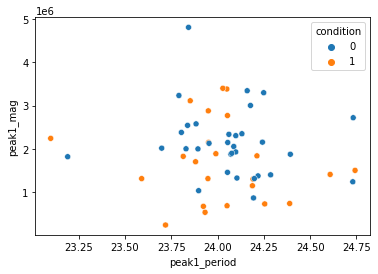

In [49]:
sns.scatterplot(data = all_freqs, x = 'peak1_period', y = 'peak1_mag', hue = 'condition')

<AxesSubplot:xlabel='peak2_period', ylabel='peak2_mag'>

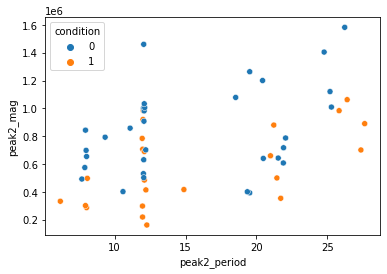

In [50]:
sns.scatterplot(data = all_freqs, x = 'peak2_period', y = 'peak2_mag', hue = 'condition')

<AxesSubplot:xlabel='peak3_period', ylabel='peak3_mag'>

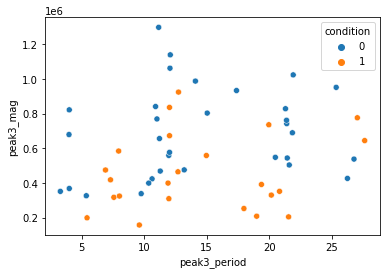

In [51]:
sns.scatterplot(data = all_freqs, x = 'peak3_period', y = 'peak3_mag', hue = 'condition')

In [52]:
by_hour_conds = condition_dfs['condition_1'].groupby(by = [condition_dfs['condition_1'].timestamp.dt.month,
                                                            condition_dfs['condition_1'].timestamp.dt.day,
                                                            condition_dfs['condition_1'].timestamp.dt.hour],
                axis = 0).agg(['sum','median','mean'],axis = 0)

In [53]:
by_hour_conds

activity                   
                                   sum median        mean
timestamp timestamp timestamp                            
5         7         12           20793  272.5  346.550000
                    13           17074  250.0  284.566667
                    14           16751  188.0  279.183333
                    15           13127  116.0  218.783333
                    16           14313  163.0  238.550000
...                                ...    ...         ...
          23        11               0    0.0    0.000000
                    12               0    0.0    0.000000
                    13               0    0.0    0.000000
                    14             684    0.0   11.400000
                    15            1908    0.0   79.500000

[388 rows x 3 columns]

In [54]:
by_hour_conds.loc[(5,7,12),('activity','sum')]

20793.0

In [55]:
condi_1 = condition_dfs['condition_1'].copy()

In [56]:
condi_1['hourly_median'] = condi_1.timestamp.apply(lambda x: by_hour_conds.loc[(x.month,x.day,x.hour),('activity','median')])
condi_1['hourly_average'] = condi_1.timestamp.apply(lambda x: by_hour_conds.loc[(x.month,x.day,x.hour),('activity','mean')])

In [57]:
condi_1.head(70)

,timestamp,activity,hourly_median,hourly_average
0,2003-05-07 12:00:00,0,272.5,346.550000
1,2003-05-07 12:01:00,143,272.5,346.550000
2,2003-05-07 12:02:00,0,272.5,346.550000
3,2003-05-07 12:03:00,20,272.5,346.550000
4,2003-05-07 12:04:00,166,272.5,346.550000
...,...,...,...,...
65,2003-05-07 13:05:00,160,250.0,284.566667
66,2003-05-07 13:06:00,296,250.0,284.566667
67,2003-05-07 13:07:00,317,250.0,284.566667
68,2003-05-07 13:08:00,338,250.0,284.566667


In [58]:
condi_1['sleeping'] = condi_1['hourly_median'].apply(lambda x: 1 if x == 0 else 0)

In [59]:
condi_1.head(70)

,timestamp,activity,hourly_median,hourly_average,sleeping
0,2003-05-07 12:00:00,0,272.5,346.550000,0
1,2003-05-07 12:01:00,143,272.5,346.550000,0
2,2003-05-07 12:02:00,0,272.5,346.550000,0
3,2003-05-07 12:03:00,20,272.5,346.550000,0
4,2003-05-07 12:04:00,166,272.5,346.550000,0
...,...,...,...,...,...
65,2003-05-07 13:05:00,160,250.0,284.566667,0
66,2003-05-07 13:06:00,296,250.0,284.566667,0
67,2003-05-07 13:07:00,317,250.0,284.566667,0
68,2003-05-07 13:08:00,338,250.0,284.566667,0


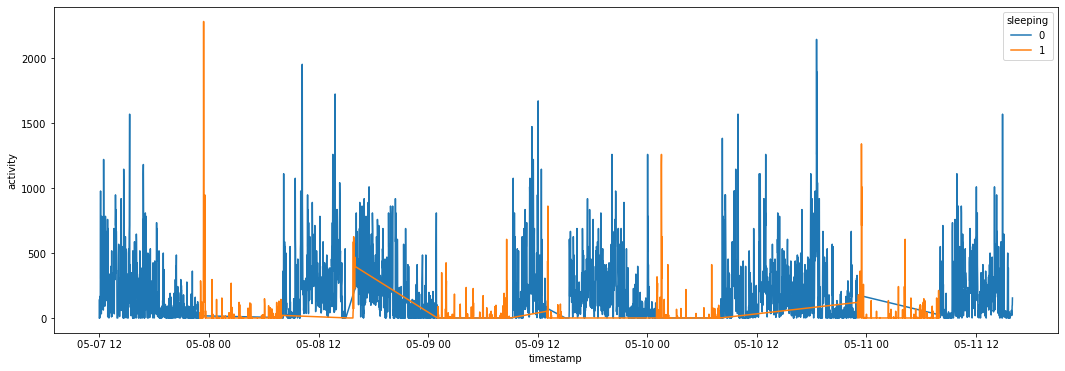

In [60]:
fig9, ax9 = plt.subplots(figsize = (18,6));
sns.lineplot(data = condi_1.iloc[:6000], x = 'timestamp', y = 'activity', hue = 'sleeping');

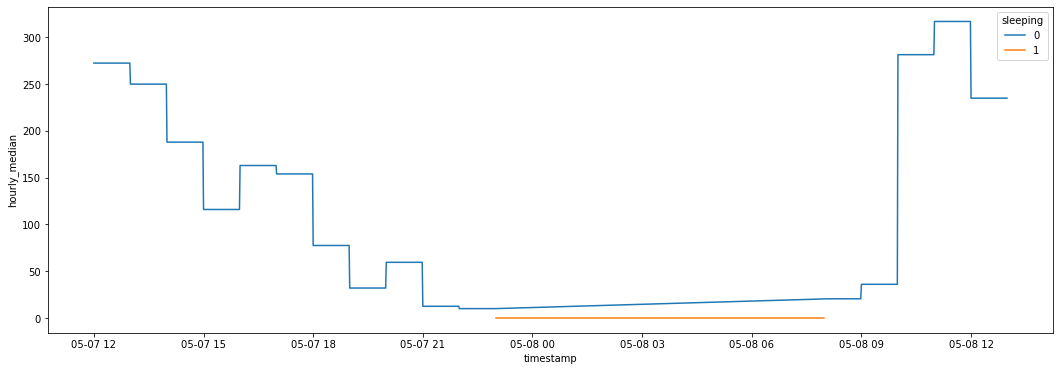

In [61]:
fig9, ax9 = plt.subplots(figsize = (18,6));
sns.lineplot(data = condi_1.iloc[:1500], x = 'timestamp', y = 'hourly_median', hue = 'sleeping');

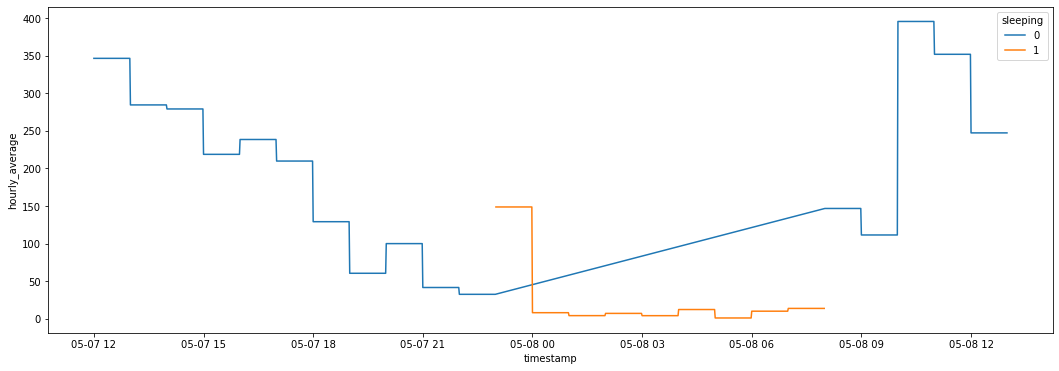

In [62]:
fig9, ax9 = plt.subplots(figsize = (18,6));
sns.lineplot(data = condi_1.iloc[:1500], x = 'timestamp', y = 'hourly_average', hue = 'sleeping');

In [63]:
by_hour_conds.loc[(5,7,23),('activity','median')]

0.0

In [64]:
condi_1['sleeping'] = condi_1['hourly_average'].apply(lambda x: 1 if x <= 30 else 0)

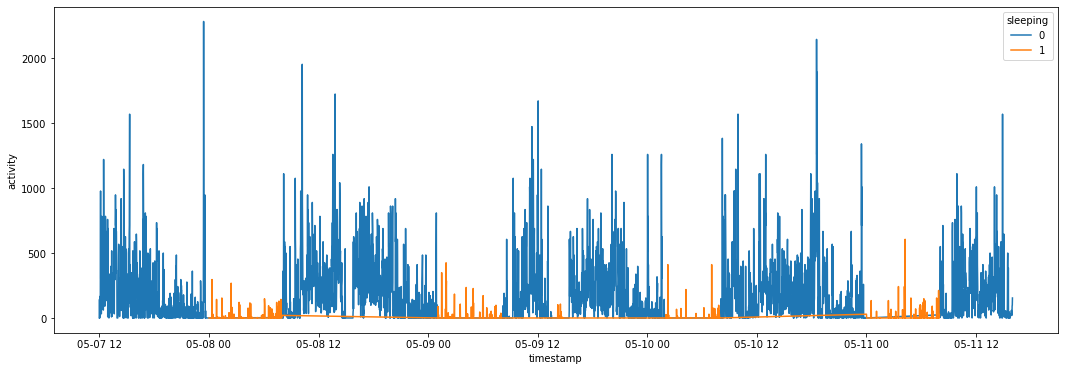

In [65]:
fig9, ax9 = plt.subplots(figsize = (18,6));
sns.lineplot(data = condi_1.iloc[:6000], x = 'timestamp', y = 'activity', hue = 'sleeping');

In [66]:
cont_1 = control_dfs['control_1'].copy()
by_hour_conts = cont_1.groupby(by = [cont_1.timestamp.dt.month,
                                    cont_1.timestamp.dt.day,
                                    cont_1.timestamp.dt.hour],
                axis = 0).agg(['sum','median','mean'],axis = 0)

In [67]:
cont_1['hourly_median'] = cont_1.timestamp.apply(lambda x: by_hour_conts.loc[(x.month,x.day,x.hour),('activity','median')])
cont_1['hourly_average'] = cont_1.timestamp.apply(lambda x: by_hour_conts.loc[(x.month,x.day,x.hour),('activity','mean')])

In [68]:
cont_1['sleeping'] = cont_1['hourly_average'].apply(lambda x: 1 if x <= 30 else 0)

In [69]:
cont_1.head(70)

,timestamp,activity,hourly_median,hourly_average,sleeping
0,2003-03-18 15:00:00,60,78.0,156.483333,0
1,2003-03-18 15:01:00,0,78.0,156.483333,0
2,2003-03-18 15:02:00,264,78.0,156.483333,0
3,2003-03-18 15:03:00,662,78.0,156.483333,0
4,2003-03-18 15:04:00,293,78.0,156.483333,0
...,...,...,...,...,...
65,2003-03-18 16:05:00,0,98.0,264.550000,0
66,2003-03-18 16:06:00,3,98.0,264.550000,0
67,2003-03-18 16:07:00,0,98.0,264.550000,0
68,2003-03-18 16:08:00,25,98.0,264.550000,0


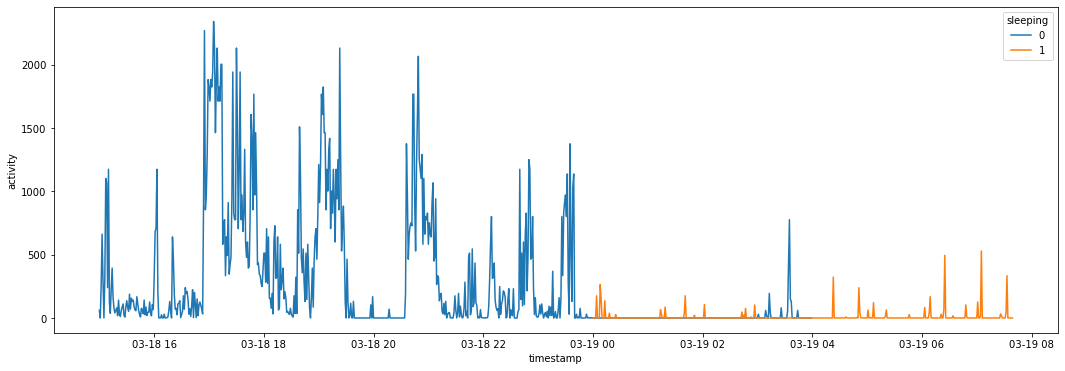

In [70]:
fig9, ax9 = plt.subplots(figsize = (18,6));
sns.lineplot(data = cont_1.iloc[:1000], x = 'timestamp', y = 'activity', hue = 'sleeping');

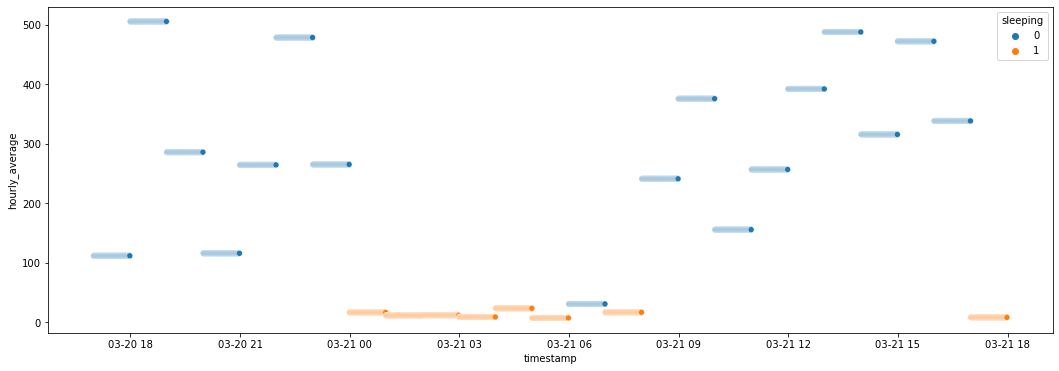

In [71]:
fig9, ax9 = plt.subplots(figsize = (18,6));
sns.scatterplot(data = cont_1.iloc[3000:4500], x = 'timestamp', y = 'hourly_average', hue = 'sleeping');

In [72]:
cont_1['sleeping'] = cont_1['hourly_median'].apply(lambda x: 1 if x == 0 else 0)

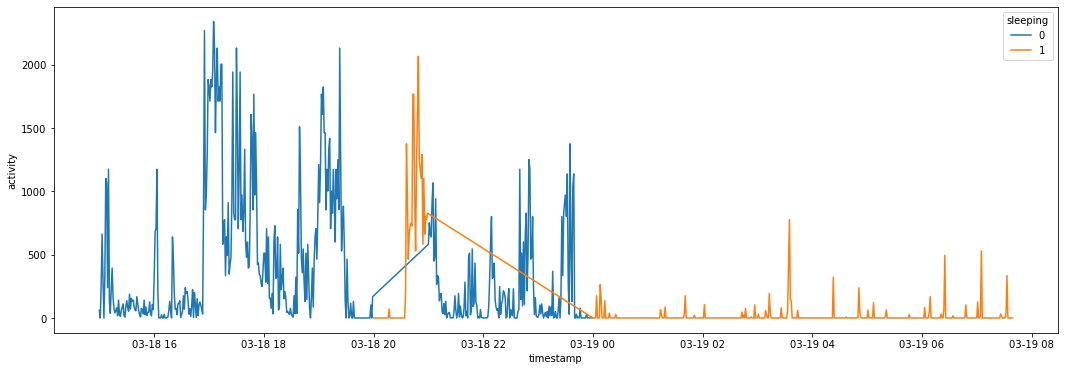

In [73]:
fig9, ax9 = plt.subplots(figsize = (18,6));
sns.lineplot(data = cont_1.iloc[:1000], x = 'timestamp', y = 'activity', hue = 'sleeping');

In [74]:
cont_1.timestamp.dt.minute

0         0
1         1
2         2
3         3
4         4
         ..
51606     6
51607     7
51608     8
51609     9
51610    10
Name: timestamp, Length: 51611, dtype: int64

In [75]:
cont_1_h = control_dfs['control_1'].copy()
cont_1_h['hour_half'] = cont_1_h.timestamp.apply(lambda x: 1 if x.minute < 30 else 0 )
by_half_hour_conts = cont_1_h.groupby(by = [cont_1_h.timestamp.dt.month,
                                    cont_1_h.timestamp.dt.day,
                                    cont_1_h.timestamp.dt.hour,
                                    cont_1_h.hour_half],
                axis = 0).agg(['sum','median','mean'],axis = 0)

In [76]:
by_half_hour_conts.head()

activity                   
                                             sum median        mean
timestamp timestamp timestamp hour_half                            
3         18        15        0             2431   68.0   81.033333
                              1             6958   88.0  231.933333
                    16        0            10638  118.5  354.600000
                              1             5235   57.0  174.500000
                    17        0            26947  802.0  898.233333

In [77]:
cont_1_h

,timestamp,activity,hour_half
0,2003-03-18 15:00:00,60,1
1,2003-03-18 15:01:00,0,1
2,2003-03-18 15:02:00,264,1
3,2003-03-18 15:03:00,662,1
4,2003-03-18 15:04:00,293,1
...,...,...,...
51606,2003-04-23 12:06:00,3,1
51607,2003-04-23 12:07:00,3,1
51608,2003-04-23 12:08:00,3,1
51609,2003-04-23 12:09:00,3,1


In [78]:
cont_1_h['hourly_median'] = cont_1_h.apply(lambda x: by_half_hour_conts.loc[(x[0].month,x[0].day,x[0].hour,x[2]),('activity','median')], axis = 1)
cont_1_h['hourly_average'] = cont_1_h.apply(lambda x: by_half_hour_conts.loc[(x[0].month,x[0].day,x[0].hour,x[2]),('activity','mean')], axis = 1)

In [79]:
cont_1_h.head(61)

,timestamp,activity,hour_half,hourly_median,hourly_average
0,2003-03-18 15:00:00,60,1,88.0,231.933333
1,2003-03-18 15:01:00,0,1,88.0,231.933333
2,2003-03-18 15:02:00,264,1,88.0,231.933333
3,2003-03-18 15:03:00,662,1,88.0,231.933333
4,2003-03-18 15:04:00,293,1,88.0,231.933333
...,...,...,...,...,...
56,2003-03-18 15:56:00,42,0,68.0,81.033333
57,2003-03-18 15:57:00,17,0,68.0,81.033333
58,2003-03-18 15:58:00,106,0,68.0,81.033333
59,2003-03-18 15:59:00,66,0,68.0,81.033333


In [80]:
cont_1_h['sleeping'] = cont_1_h['hourly_average'].apply(lambda x: 1 if x <= 30 else 0)

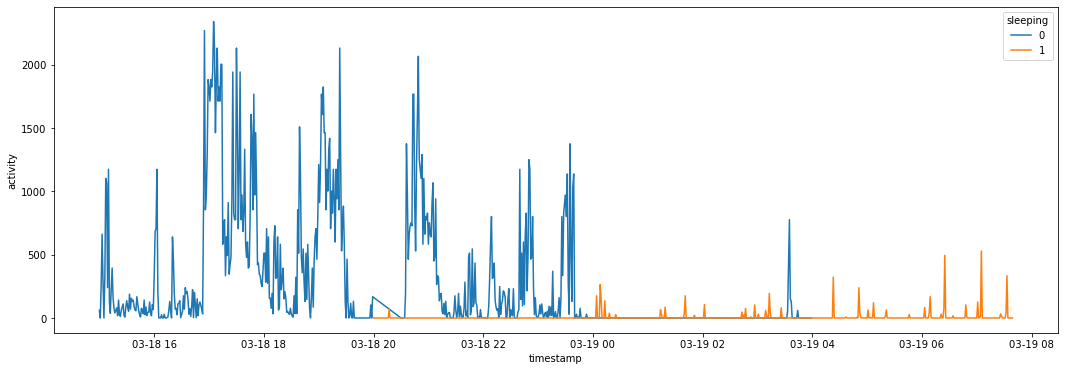

In [81]:
fig9, ax9 = plt.subplots(figsize = (18,6));
sns.lineplot(data = cont_1_h.iloc[:1000], x = 'timestamp', y = 'activity', hue = 'sleeping');

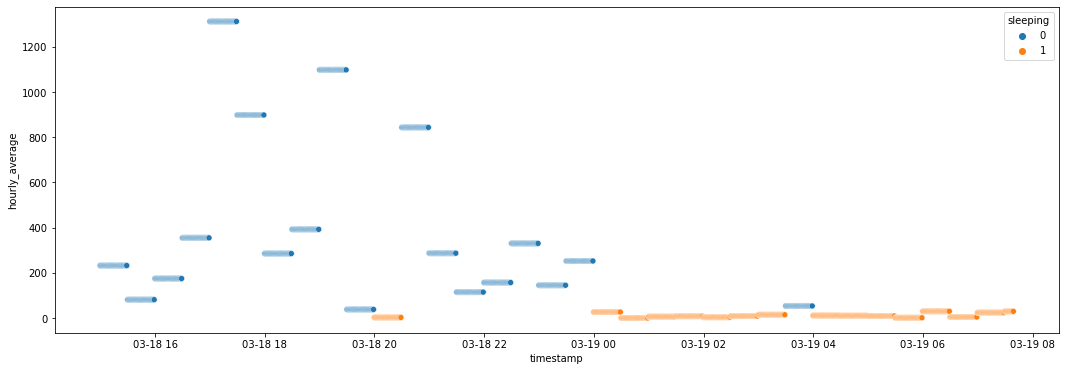

In [82]:
fig9, ax9 = plt.subplots(figsize = (18,6));
sns.scatterplot(data = cont_1_h.iloc[:1000], x = 'timestamp', y = 'hourly_average', hue = 'sleeping');

In [83]:
cont_1_h['sleeping'] = cont_1_h['hourly_median'].apply(lambda x: 1 if x == 0 else 0)

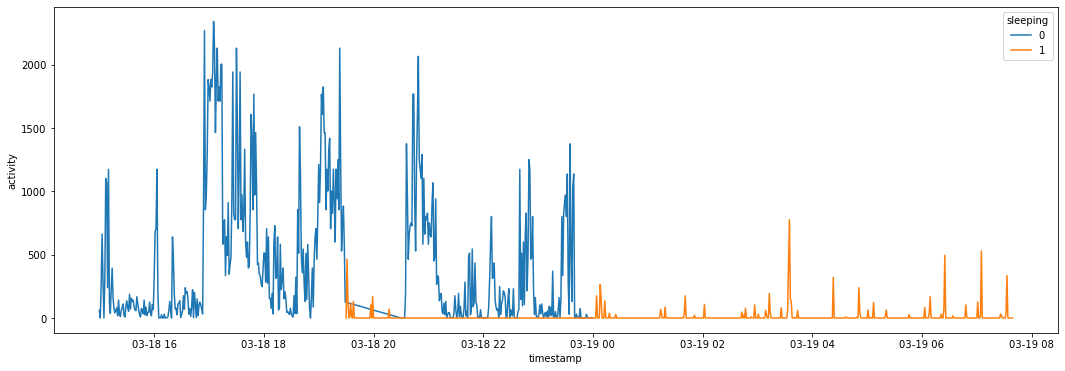

In [84]:
fig9, ax9 = plt.subplots(figsize = (18,6));
sns.lineplot(data = cont_1_h.iloc[:1000], x = 'timestamp', y = 'activity', hue = 'sleeping');

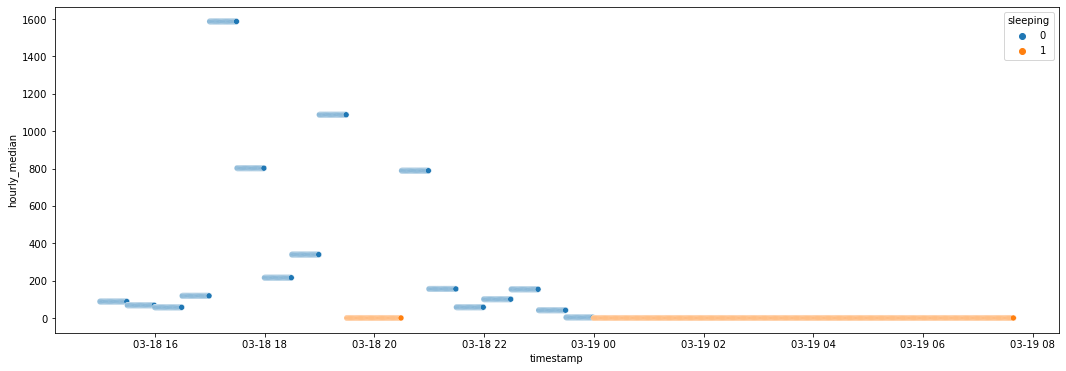

In [85]:
fig9, ax9 = plt.subplots(figsize = (18,6));
sns.scatterplot(data = cont_1_h.iloc[:1000], x = 'timestamp', y = 'hourly_median', hue = 'sleeping');

In [238]:
cond_1_h = condition_dfs['condition_1'].copy()
cond_1_h['hour_half'] = cond_1_h.timestamp.apply(lambda x: 1 if x.minute < 30 else 0 )
by_half_hour_conds = cond_1_h.groupby(by = [cond_1_h.timestamp.dt.month,
                                    cond_1_h.timestamp.dt.day,
                                    cond_1_h.timestamp.dt.hour,
                                    cond_1_h.hour_half],
                axis = 0).agg(['sum','median','mean','max', 'std', 'var', lambda x: x.ne(0).sum()],axis = 0)
cond_1_h['hourly_median'] = cond_1_h.apply(lambda x: by_half_hour_conds.loc[(x[0].month,x[0].day,x[0].hour,x[2]),('activity','median')], axis = 1)
cond_1_h['hourly_average'] = cond_1_h.apply(lambda x: by_half_hour_conds.loc[(x[0].month,x[0].day,x[0].hour,x[2]),('activity','mean')], axis = 1)

In [249]:
by_half_hour_conds.loc[(5,8)]

activity                                       \
                         sum median        mean   max         std   
timestamp hour_half                                                 
0         0              151    0.0    5.033333   143   26.098597   
          1              329    0.0   10.966667   296   54.112580   
1         0               30    0.0    1.000000    17    3.464102   
          1              215    0.0    7.166667   154   28.687476   
2         0              112    0.0    3.733333    82   15.763190   
          1              312    0.0   10.400000   268   49.224748   
3         0               17    0.0    0.566667    11    2.112089   
          1              225    0.0    7.500000   120   28.238821   
4         0              261    0.0    8.700000   111   27.258849   
          1              472    0.0   15.733333   116   32.629512   
5         0               55    0.0    1.833333    26    6.034860   
          1                3    0.0    0.100000     3    0.547723   
6         0              243    0.0    8.100000    94   24.919664   
          1              357    0.0   11.900000   148   36.943900   
7         0              614    0.0   20.466667   143   38.864693   
          1              208    0.0    6.933333   120   23.170929   
8         0             1062    3.0   35.400000   550  102.359273   
          1             7742  234.5  258.066667  1111  254.405180   
9         0             3544   96.0  118.133333   454  130.373134   
          1             3143   20.5  104.766667  1076  233.592289   
10        0             9969  268.0  332.300000   948  242.295936   
          1            13770  286.0  459.000000  1954  397.834136   
11        0             9706  291.0  323.533333   712  157.627613   
          1            11411  333.0  380.366667   890  169.430178   
12        0             8168  250.5  272.266667   587  142.912545   
          1             6672  215.5  222.400000   783  141.269515   
13        0            13797  361.0  459.900000  1725  406.193291   
          1             7085  212.0  236.166667   550  139.358897   
14        0             2435    0.0   81.166667   533  152.919651   
          1            14358  461.5  478.600000  1042  236.745986   
15        0             4555    0.0  151.833333   626  222.211313   
          1                0    0.0    0.000000     0    0.000000   
16        0            11077  361.0  369.233333   890  309.290588   
          1            11013  306.0  367.100000   809  172.779978   
17        0            11376  296.0  379.200000  1010  232.129779   
          1            12302  317.0  410.066667   919  258.925090   
18        0             8124  204.0  270.800000   712  197.886314   
          1            10344  317.0  344.800000   759  179.158069   
19        0             9037  272.5  301.233333   862  228.724301   
          1             6777  212.0  225.900000   689  193.816541   
20        0             2209   17.5   73.633333   606  136.027503   
          1             7650   96.5  255.000000   919  308.986106   
21        0             5107  151.5  170.233333   689  159.218497   
          1             2096   27.0   69.866667   568  119.768090   
22        0             1775   15.5   59.166667   411   96.276571   
          1             1016    5.5   33.866667   143   49.180690   
23        0             1799   16.0   59.966667   485  102.686830   
          1             2273   10.0   75.766667   485  134.852329   

                                               
                               var <lambda_0>  
timestamp hour_half                            
0         0             681.136782          2  
          1            2928.171264          3  
1         0              12.000000          3  
          1             822.971264          4  
2         0             248.478161          2  
          1            2423.075862          3  
3         0               4.460920          3  
          1         

In [296]:
cond_1_h_med = cond_1_h.copy()
cond_1_h_med['sleeping'] = cond_1_h_med['hourly_median'].apply(lambda x: 1 if x <=5 else 0)

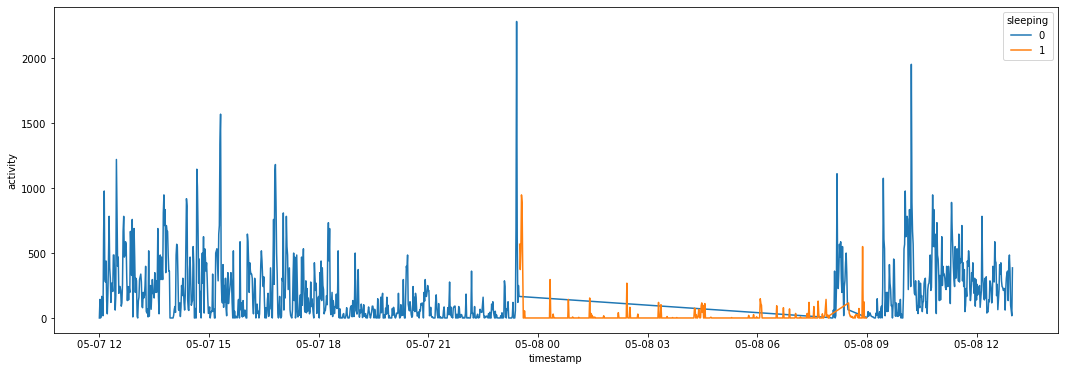

In [297]:
fig9, ax9 = plt.subplots(figsize = (18,6));
sns.lineplot(data = cond_1_h_med.iloc[:1500], x = 'timestamp', y = 'activity', hue = 'sleeping');

In [298]:
cond_1_h_avg = cond_1_h.copy()
cond_1_h_avg['sleeping'] = cond_1_h_avg['hourly_average'].apply(lambda x: 1 if x <= 35 else 0)

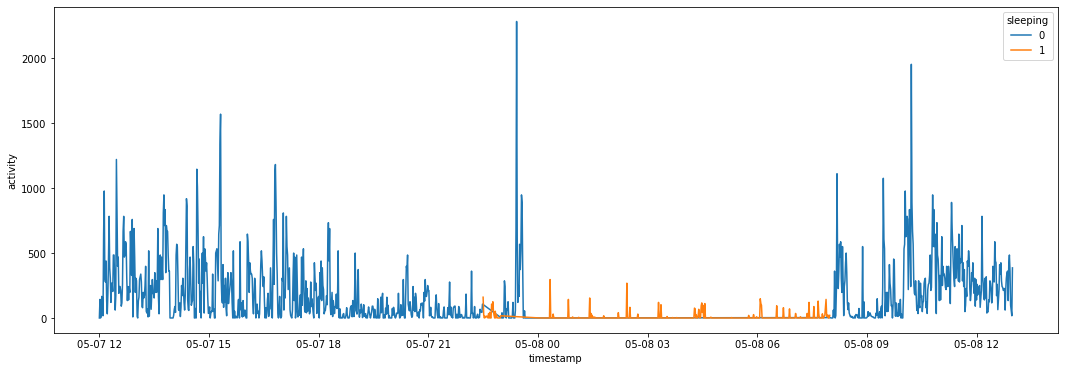

In [299]:
fig9, ax9 = plt.subplots(figsize = (18,6));
sns.lineplot(data = cond_1_h_avg.iloc[:1500], x = 'timestamp', y = 'activity', hue = 'sleeping');

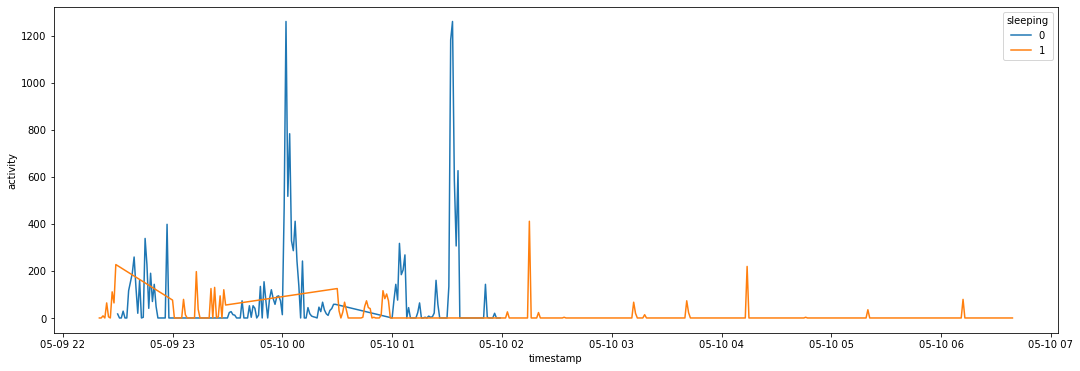

In [300]:
fig9, ax9 = plt.subplots(figsize = (18,6));
sns.lineplot(data = cond_1_h_avg.iloc[3500:4000], x = 'timestamp', y = 'activity', hue = 'sleeping');

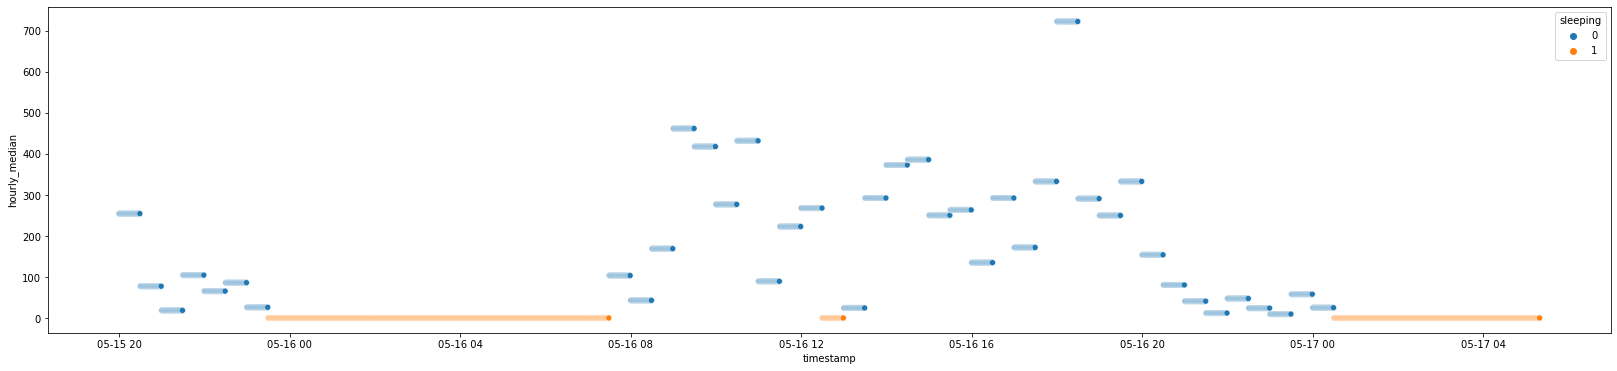

In [306]:
fig9, ax9 = plt.subplots(figsize = (28,6));
sns.scatterplot(data = cond_1_h_med.iloc[12000:14000], x = 'timestamp', y = 'hourly_median', hue = 'sleeping');

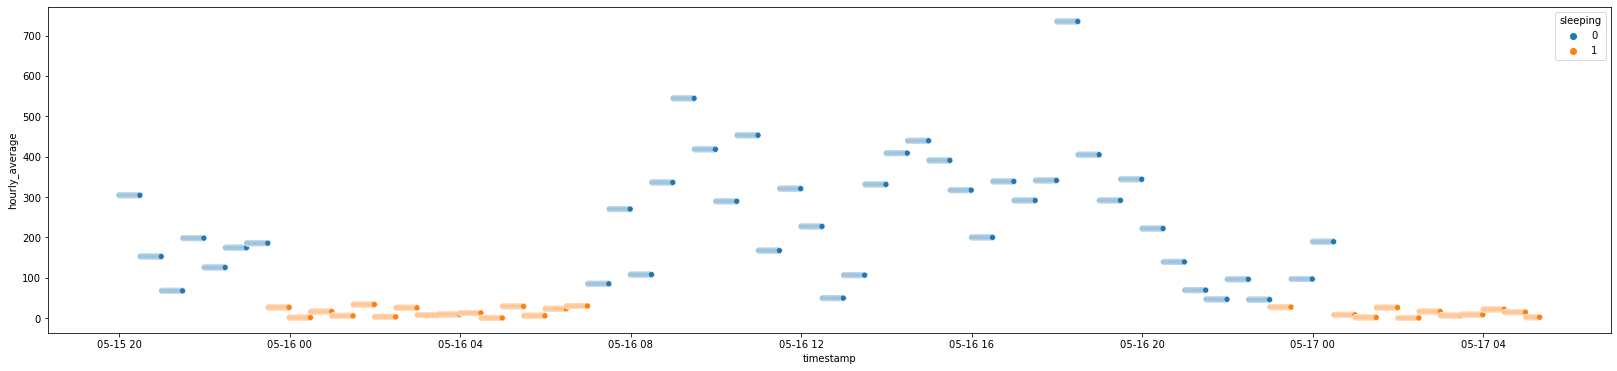

In [307]:
fig9, ax9 = plt.subplots(figsize = (28,6));
sns.scatterplot(data = cond_1_h_avg.iloc[12000:14000], x = 'timestamp', y = 'hourly_average', hue = 'sleeping');

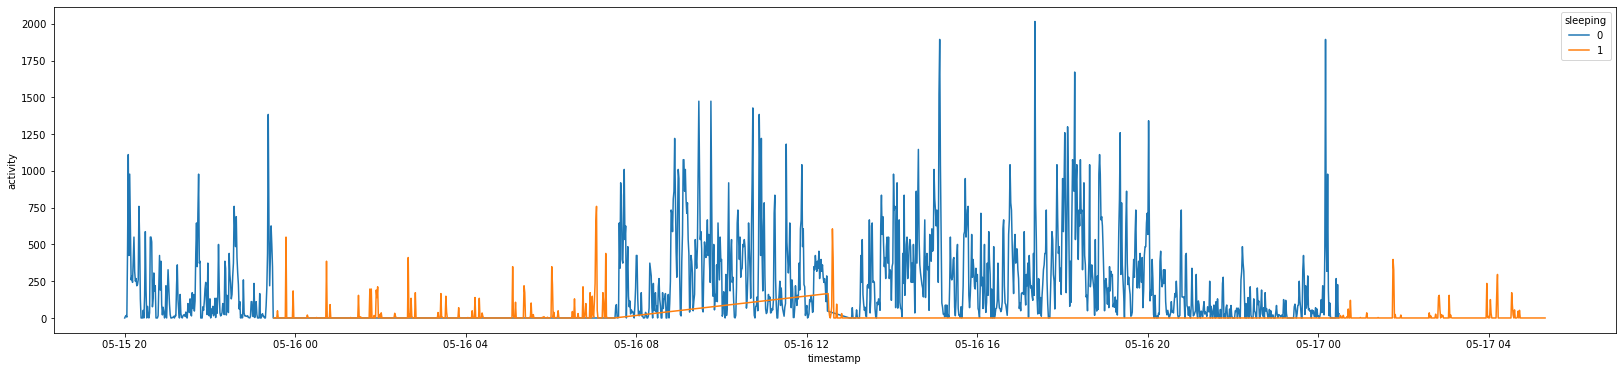

In [309]:
fig9, ax9 = plt.subplots(figsize = (28,6));
sns.lineplot(data = cond_1_h_med.iloc[12000:14000], x = 'timestamp', y = 'activity', hue = 'sleeping');

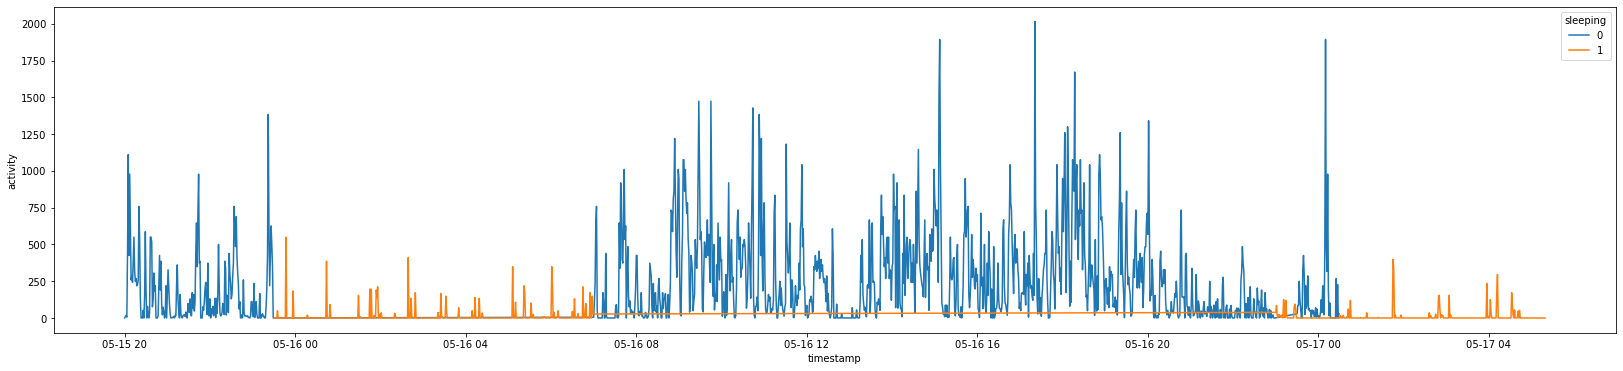

In [310]:
fig9, ax9 = plt.subplots(figsize = (28,6));
sns.lineplot(data = cond_1_h_avg.iloc[12000:14000], x = 'timestamp', y = 'activity', hue = 'sleeping');

In [225]:
by_half_hour_conds.loc[(5,21,19),('activity','mean')]

hour_half
0    153.333333
1     83.433333
Name: (activity, mean), dtype: float64

In [381]:
cond_2_h = condition_dfs['condition_2'].copy()
cond_2_h['hour_half'] = cond_2_h.timestamp.apply(lambda x: 1 if x.minute < 30 else 0 )
by_half_hour_cond_2 = cond_2_h.groupby(by = [cond_2_h.timestamp.dt.month,
                                    cond_2_h.timestamp.dt.day,
                                    cond_2_h.timestamp.dt.hour,
                                    cond_2_h.hour_half],
                axis = 0).agg(['sum','median','mean','max', 'std', 'var', ('restful_mins',lambda x: x.le(7).sum()),('zero_act_mins',lambda x: x.eq(0).sum())],axis = 0)
by_half_hour_cond_2['zero_med_bool'] = by_half_hour_cond_2.loc[:,('activity','median')].apply(lambda x: 1 if x <= 7 else 0)
by_half_hour_cond_2['avg_thresh_bool'] = by_half_hour_cond_2.loc[:,('activity','mean')].apply(lambda x: 1 if x <= 35 else 0)
by_half_hour_cond_2['resting'] = by_half_hour_cond_2.apply(lambda x: 1 if ((x[8] == 1) & (x[9] == 1)) else 0, axis = 1)
by_half_hour_cond_2['night'] = by_half_hour_cond_2.apply(lambda x: 1 if ((x.name[2] >= 21) | (x.name[2] < 7)) else 0, axis = 1)
cond_2_h['zero_med_bool'] = cond_2_h.apply(lambda x: by_half_hour_cond_2.loc[(x[0].month,x[0].day,x[0].hour,x[2]),('zero_med_bool','')], axis = 1)
cond_2_h['avg_thresh_bool'] = cond_2_h.apply(lambda x: by_half_hour_cond_2.loc[(x[0].month,x[0].day,x[0].hour,x[2]),('avg_thresh_bool','')], axis = 1)
cond_2_h['resting'] = cond_2_h.apply(lambda x: by_half_hour_cond_2.loc[(x[0].month,x[0].day,x[0].hour,x[2]),('resting','')], axis = 1)

In [382]:
by_half_hour_cond_2.iloc[0].name[2]

15

In [384]:
by_half_hour_cond_2.loc[(5,8),:]

activity                                        \
                         sum median         mean   max         std   
timestamp hour_half                                                  
0         0              919   24.0    30.633333   316   56.052613   
          1              613    4.0    20.433333   250   45.825519   
1         0              790    4.0    26.333333   349   74.094224   
          1              745    3.5    24.833333   337   69.188938   
2         0              441    3.0    14.700000   268   49.404837   
          1              105    3.0     3.500000     9    1.137147   
3         0              127    4.0     4.233333    15    2.062528   
          1              143    4.0     4.766667    35    5.727630   
4         0             4494   21.0   149.800000   945  212.003318   
          1             1210    4.0    40.333333   316   77.221729   
5         0             1457    6.5    48.566667   549  118.032924   
          1             7990  201.0   266.333333  1515  267.289632   
6         0            11713  372.0   390.433333  1006  288.095013   
          1            16897  483.0   563.233333  1886  379.167208   
7         0             4885  101.0   162.833333   515  139.181123   
          1            14742  349.0   491.400000  1665  415.264071   
8         0             9844  185.5   328.133333  1295  318.977000   
          1            14624  379.5   487.466667  1255  416.530392   
9         0            14741  460.5   491.366667  2008  457.982719   
          1            15288  468.0   509.600000  1178  361.990150   
10        0            33094  873.0  1103.133333  3736  831.792196   
          1             9991  343.0   333.033333  1073  259.312019   
11        0             6722  103.0   224.066667   733  229.282379   
          1            13233  354.5   441.100000  1515  345.542387   
12        0            12092  360.0   403.066667  1295  323.385105   
          1             6956  126.0   231.866667   781  238.051970   
13        0            13089  390.5   436.300000  1295  294.007759   
          1            17756  360.5   591.866667  1829  491.058865   
14        0            15158  316.5   505.266667  2008  466.404289   
          1             8658  208.5   288.600000   915  242.086135   
15        0            17981  445.5   599.366667  2205  498.449837   
          1            11576  285.0   385.866667  1178  349.623910   
16        0             6848  187.0   228.266667   859  203.811937   
          1            16356  605.0   545.200000  1039  286.887747   
17        0             7610  141.5   253.666667   915  247.427918   
          1             8370  181.5   279.000000   945  258.507120   
18        0             3033   40.5   101.100000   360  115.221631   
          1             6859   70.5   228.633333  1295  313.227524   
19        0             7023   56.0   234.100000  1295  383.385315   
          1             1842   14.0    61.400000   384   91.236940   
20        0              986   11.0    32.866667   277   60.491512   
          1             1293   16.0    43.100000   178   50.106335   
21        0             3717    4.0   123.900000  1039  270.540882   
          1            20435  636.5   681.166667  1515  431.637147   
22        0              853    4.0    28.433333   384   79.190161   
          1              307    4.0    10.233333    74   18.191857   
23        0               90    3.0     3.000000     3    0.000000   
          1              193    4.0     6.433333    79   13.753202   

                                                              zero_med_bool  \
                               var restful_mins zero_act_mins                 
timestamp hour_half                                                           
0         0            3141.895402           10             0             0   
          1            2099.978161           19             0             1   
1         0            5489.954023           24       

(0.0, 50.0)

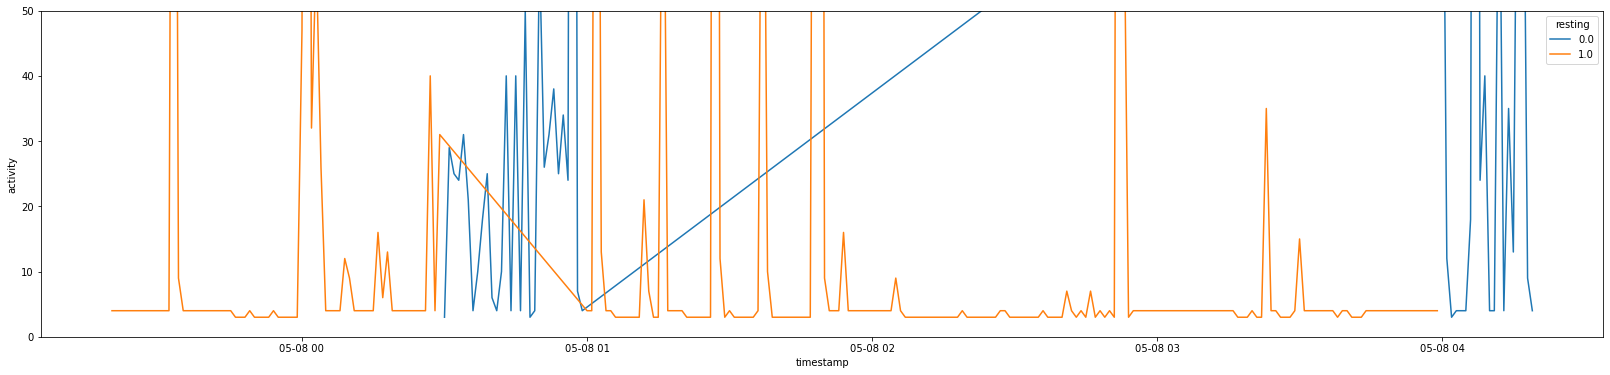

In [346]:
fig9, ax9 = plt.subplots(figsize = (28,6));
sns.lineplot(data = cond_2_h.iloc[500:800], x = 'timestamp', y = 'activity', hue = 'resting');
ax9.set_ylim((0,50))

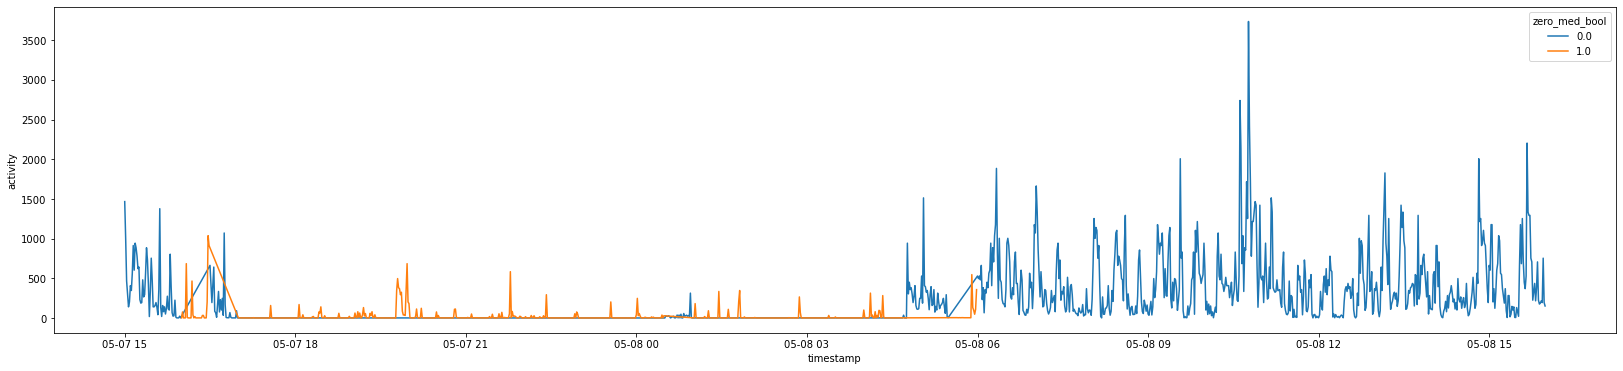

In [328]:
fig9, ax9 = plt.subplots(figsize = (28,6));
sns.lineplot(data = cond_2_h.iloc[:1500], x = 'timestamp', y = 'activity', hue = 'zero_med_bool');

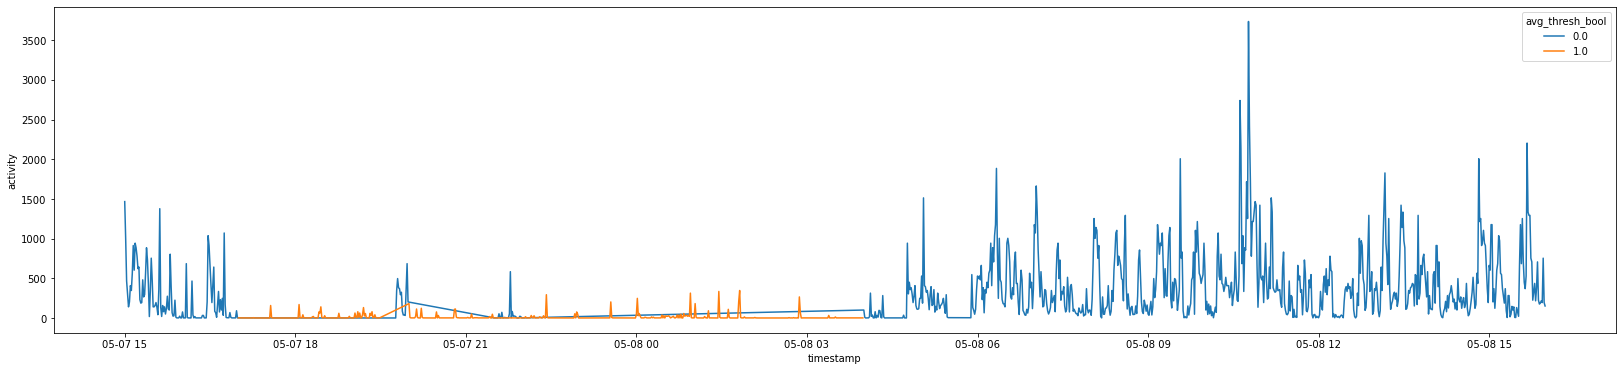

In [329]:
fig9, ax9 = plt.subplots(figsize = (28,6));
sns.lineplot(data = cond_2_h.iloc[:1500], x = 'timestamp', y = 'activity', hue = 'avg_thresh_bool');

In [318]:
cond_2_h[cond_2_h.activity <= 10].activity.value_counts()

4     8484
9     6450
7     4487
6     1799
10    1404
3     1322
0        2
Name: activity, dtype: int64

In [320]:
for subject in cleaned_conditions:
    print("----------------------------------")
    print(f"Subject: {subject}")
    df = condition_dfs[subject]
    print(df[df.activity <=10].activity.value_counts())
    print("----------------------------------")
for subject in cleaned_controls:
    print("----------------------------------")
    print(f"Subject: {subject}")
    df = control_dfs[subject]
    print(df[df.activity <=10].activity.value_counts())
    print("----------------------------------")

----------------------------------
Subject: condition_1
0    10902
3      309
8      160
5      146
9      140
6       77
Name: activity, dtype: int64
----------------------------------
----------------------------------
Subject: condition_10
0     7806
3      145
4       76
7       64
9       60
10      51
6       35
Name: activity, dtype: int64
----------------------------------
----------------------------------
Subject: condition_11
0     13097
3       381
8       127
10      122
5       111
7        60
Name: activity, dtype: int64
----------------------------------
----------------------------------
Subject: condition_12
0     10007
3       341
7       177
4       127
9       126
10       89
6        63
Name: activity, dtype: int64
----------------------------------
----------------------------------
Subject: condition_13
0     11208
3       293
6       142
4        96
8        85
10       75
9        53
5        42
Name: activity, dtype: int64
----------------------------------
-

In [398]:
def perform_agg(df_orig):
    df = df_orig.copy()
    df['hour_half'] = df.timestamp.apply(lambda x: 1 if x.minute < 30 else 0 )
    grouped_df = df.groupby(by = [df.timestamp.dt.month,
                                    df.timestamp.dt.day,
                                    df.timestamp.dt.hour,
                                    df.hour_half],
                axis = 0).agg(['sum','median','mean','max', 'std', 'var', ('restful_mins',lambda x: x.le(7).sum()),('zero_act_mins',lambda x: x.eq(0).sum())],axis = 0)
    grouped_df['zero_med_bool'] = grouped_df.loc[:,('activity','median')].apply(lambda x: 1 if x <= 7 else 0)
    grouped_df['avg_thresh_bool'] = grouped_df.loc[:,('activity','mean')].apply(lambda x: 1 if x <= 35 else 0)
    grouped_df['resting'] = grouped_df.apply(lambda x: 1 if ((x[8] == 1) & (x[9] == 1)) else 0, axis = 1)
    grouped_df = grouped_df.drop(columns = ['zero_med_bool','avg_thresh_bool'])
    grouped_df['night'] = grouped_df.apply(lambda x: 1 if ((x.name[2] >= 21) | (x.name[2] < 7)) else 0, axis = 1)
    return grouped_df

In [399]:
perform_agg(condition_dfs['condition_2']).head()

activity                           \
                                             sum median        mean   max   
timestamp timestamp timestamp hour_half                                     
5         7         15        0             5396  120.5  179.866667  1379   
                              1            16197  483.0  539.900000  1468   
                    16        0             5206   75.0  173.533333  1073   
                              1             3608    4.0  120.266667  1039   
                    17        0              252    3.0    8.400000   160   

                                                                    \
                                                std            var   
timestamp timestamp timestamp hour_half                              
5         7         15        0          278.224510   77408.878161   
                              1          320.033764  102421.610345   
                    16        0          251.264489   63133.843678   
                              1          277.117295   76793.995402   
                    17        0           28.642385     820.386207   

                                                                   resting  \
                                        restful_mins zero_act_mins           
timestamp timestamp timestamp hour_half                                      
5         7         15        0                    4             0       0   
                              1                    0             0       0   
                    16        0                    9             0       0   
                              1                   19             0       0   
                    17        0                   29             0       1   

                                        night  
                                               
timestamp timestamp timestamp hour_half        
5         7         15        0             0  
                              1             0  
                    16        0             0  
                              1             0  
                    17        0             0

In [400]:
by_half_hour_cond_2.head()

activity                           \
                                             sum median        mean   max   
timestamp timestamp timestamp hour_half                                     
5         7         15        0             5396  120.5  179.866667  1379   
                              1            16197  483.0  539.900000  1468   
                    16        0             5206   75.0  173.533333  1073   
                              1             3608    4.0  120.266667  1039   
                    17        0              252    3.0    8.400000   160   

                                                                    \
                                                std            var   
timestamp timestamp timestamp hour_half                              
5         7         15        0          278.224510   77408.878161   
                              1          320.033764  102421.610345   
                    16        0          251.264489   63133.843678   
                              1          277.117295   76793.995402   
                    17        0           28.642385     820.386207   

                                                                    \
                                        restful_mins zero_act_mins   
timestamp timestamp timestamp hour_half                              
5         7         15        0                    4             0   
                              1                    0             0   
                    16        0                    9             0   
                              1                   19             0   
                    17        0                   29             0   

                                        zero_med_bool avg_thresh_bool resting  \
                                                                                
timestamp timestamp timestamp hour_half                                         
5         7         15        0                     0               0       0   
                              1                     0               0       0   
                    16        0                     0               0       0   
                              1                     1               0       0   
                    17        0                     1               1       1   

                                        night  
                                               
timestamp timestamp timestamp hour_half        
5         7         15        0             0  
                              1             0  
                    16        0             0  
                              1             0  
                    17        0             0

In [401]:
grouped_condition_dfs = {}
for subject in cleaned_conditions:
    grouped_df = perform_agg(condition_dfs[subject])
    grouped_condition_dfs.update({subject: grouped_df})
grouped_control_dfs = {}
for subject in cleaned_controls:
    grouped_df = perform_agg(control_dfs[subject])
    grouped_control_dfs.update({subject: grouped_df})

In [402]:
grouped_condition_dfs['condition_10'].head()

activity                           \
                                             sum median        mean   max   
timestamp timestamp timestamp hour_half                                     
8         31        9         0               32    0.0    1.066667    29   
                              1              175    0.0    5.833333    91   
                    10        0              188    0.0    6.266667    50   
                              1              107    0.0    3.566667    41   
                    11        0            23106  721.0  770.200000  1665   

                                                                    \
                                                std            var   
timestamp timestamp timestamp hour_half                              
8         31        9         0            5.304086      28.133333   
                              1           17.855905     318.833333   
                    10        0           14.112683     199.167816   
                              1           11.028750     121.633333   
                    11        0          365.248748  133406.648276   

                                                                   resting  \
                                        restful_mins zero_act_mins           
timestamp timestamp timestamp hour_half                                      
8         31        9         0                   29            28       1   
                              1                   25            25       1   
                    10        0                   25            24       1   
                              1                   27            27       1   
                    11        0                    0             0       0   

                                        night  
                                               
timestamp timestamp timestamp hour_half        
8         31        9         0             0  
                              1             0  
                    10        0             0  
                              1             0  
                    11        0             0

In [403]:
grouped_control_dfs['control_10'].head()

activity                         \
                                             sum median       mean  max   
timestamp timestamp timestamp hour_half                                   
11        18        9         0               61    3.0   2.033333    8   
                              1              311    3.0  10.366667  130   
                    10        0              104    3.0   3.466667   17   
                              1               90    3.0   3.000000    3   
                    11        0              687    0.0  22.900000  667   

                                                                   \
                                                std           var   
timestamp timestamp timestamp hour_half                             
11        18        9         0            2.189053      4.791954   
                              1           26.076126    679.964368   
                    10        0            2.556039      6.533333   
                              1            0.000000      0.000000   
                    11        0          121.705793  14812.300000   

                                                                   resting  \
                                        restful_mins zero_act_mins           
timestamp timestamp timestamp hour_half                                      
11        18        9         0                   28            13       1   
                              1                   27             0       1   
                    10        0                   29             0       1   
                              1                   30             0       1   
                    11        0                   28            28       1   

                                        night  
                                               
timestamp timestamp timestamp hour_half        
11        18        9         0             0  
                              1             0  
                    10        0             0  
                              1             0  
                    11        0             0